In [16]:
from lib.data import MegaPlantDataset
from lib.config import Directories
from PIL import Image
from torchvision import transforms

import seaborn as sns
import matplotlib.pyplot as plt
from iragca.matplotlib import Styles

plt.style.use(Styles.ML.value)

IMAGE_SIZE = (32, 32)
transform_pipeline = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

dataset = MegaPlantDataset(data_path=Directories.INTERIM_DATA_DIR.value / "leaves", transforms=transform_pipeline)

In [17]:
dataset.STATUS_MAP

{'healthy': 0, 'unhealthy': 1}

In [18]:
dataset[0][0].shape

torch.Size([3, 32, 32])

In [19]:
# sum(sample[1] for sample in dataset) / len(dataset)

In [20]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, channels: int, output_dim: int = 1):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.network(x)

In [21]:
from torch.utils.data import DataLoader, random_split

BATCH_SIZE = 32

train_data, val_data, test_data = random_split(dataset, [0.7, 0.2, 0.1])

train_loader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

In [22]:
from torch.optim import SGD
from torch.nn import MSELoss
from iragca.ml import RunLogger
from tqdm.notebook import tqdm
import torch
from sklearn.metrics import f1_score, accuracy_score

model = SimpleCNN(channels=3, output_dim=1)
optimizer = SGD(model.parameters(), lr=0.01)
criterion = MSELoss()
EPOCHS = 50
THRESHOLD = 0.5

def train(model, optimizer, criterion, epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    logger = RunLogger(
        epochs, 
        display_progress=True, 
        update_interval=1, 
        notebook=True, 
        unit="epoch", 
        desc="Epochs"
    )

    model.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        y_trues, y_preds = [], []

        for inputs, targets in tqdm(train_loader, total=len(train_loader), position=1, leave=False, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets.float())
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            y_pred = (outputs.squeeze() >= THRESHOLD).long()
            y_trues.extend(targets.cpu().numpy())
            y_preds.extend(y_pred.cpu().numpy())

        train_loss = total_loss / len(train_loader)
        train_accuracy = accuracy_score(y_trues, y_preds)
        train_f1_score = f1_score(y_trues, y_preds)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            val_y_trues, val_y_preds = [], []
            for inputs, targets in tqdm(val_loader, total=len(val_loader), position=1, leave=False, desc="Validating"):
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), targets.float())
                val_loss += loss.item()
                val_y_trues.extend(targets.cpu().numpy())
                val_y_preds.extend((outputs.squeeze() >= THRESHOLD).long().cpu().numpy())
            val_loss = val_loss / len(val_loader)
            val_accuracy = accuracy_score(val_y_trues, val_y_preds)
            val_f1_score = f1_score(val_y_trues, val_y_preds)

        logger.log_metrics({
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score
            }, epoch)

    return logger

logger = train(model, optimizer, criterion, epochs=EPOCHS)

Epochs:   0%|          | 0/50 [00:00<?, ?epoch/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Training:   0%|          | 0/1137 [00:00<?, ?it/s]

Validating:   0%|          | 0/325 [00:00<?, ?it/s]

Text(0.5, 1.0, 'F1 Score over Epochs')

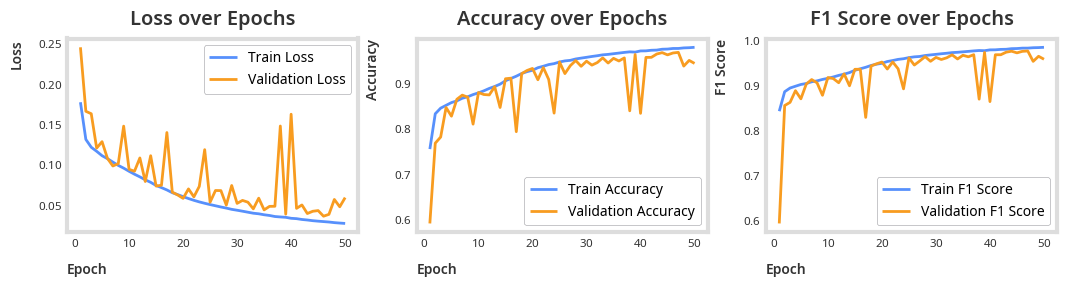

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2.5))

sns.lineplot(x=logger.steps, y=logger.train_loss, label='Train Loss', ax=ax[0])
sns.lineplot(x=logger.steps, y=logger.val_loss, label='Validation Loss', ax=ax[0])
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss over Epochs')

sns.lineplot(x=logger.steps, y=logger.train_accuracy, label='Train Accuracy', ax=ax[1])
sns.lineplot(x=logger.steps, y=logger.val_accuracy, label='Validation Accuracy', ax=ax[1])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy over Epochs')

sns.lineplot(x=logger.steps, y=logger.train_f1_score, label='Train F1 Score', ax=ax[2])
sns.lineplot(x=logger.steps, y=logger.val_f1_score, label='Validation F1 Score', ax=ax[2])
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('F1 Score')
ax[2].set_title('F1 Score over Epochs')